**Chapter 10 – Introduction to Artificial Neural Networks**

_This notebook contains all the sample code in chapter 10._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Loading the Data

From the original data, we extract the student response tf-idf vector as the input feature, and the binary correctness value as the output label. In this way it becomes a binary classification task, where we aim to predict if the student's answer is correct or not based on the tf-idf vector of the answer.

We randomly select 80% samples for training, and the remaining 20% as test set. 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

beetles_full = pd.read_csv('beetleTrainingData.csv')
beetles_feature = beetles_full[beetles_full.columns[~beetles_full.columns.str.contains('_RA')]].drop(['accuracy_num', 'accuracy_txt'], axis=1).as_matrix()
beetles_label = beetles_full.accuracy_txt.apply(lambda a: int(a == 'correct')).as_matrix()

beetles_train_feature, beetles_test_feature, beetles_train_label, beetles_test_label = train_test_split(
    beetles_feature, beetles_label, test_size=0.2, random_state=42)

In [3]:
beetles_train_feature.shape

(3152, 995)

In [4]:
beetles_train_label.shape

(3152,)

In [5]:
beetles_test_feature.shape

(789, 995)

In [6]:
beetles_test_label.shape

(789,)

# Perceptron

A perceptron is the simplest type of neuron, where the input and output satisfy the relationship shown in the image below:

<img src="perceptron.png">

In [7]:
import numpy as np
from sklearn.linear_model import Perceptron

per_clf = Perceptron(random_state=42) # The random state is used to shuffle the data

per_clf.fit(beetles_train_feature, beetles_train_label)
training_accuracy = per_clf.score(beetles_train_feature, beetles_train_label)
training_accuracy

0.71573604060913709

In [8]:
test_accuracy = per_clf.score(beetles_test_feature, beetles_test_label)
test_accuracy

0.60076045627376429

In [9]:
per_clf.coef_[0].shape # the shape of w

(995,)

In [10]:
per_clf.intercept_ # the value of b

array([ 0.])

# Activation functions

A perceptron uses the stepwise function to determine the output. In other neural networks, more complicated activation functions are used.

In [11]:
def logit(z): # logistic
    return 1 / (1 + np.exp(-z))

def relu(z): # rectified linear unit
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

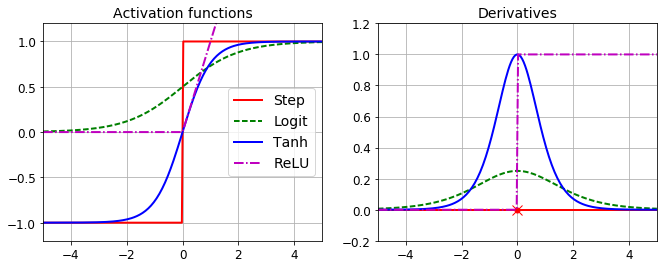

In [12]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, logit(z), "g--", linewidth=2, label="Logit")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(logit, z), "g--", linewidth=2, label="Logit")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("activation_functions_plot")
plt.show()

In [13]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

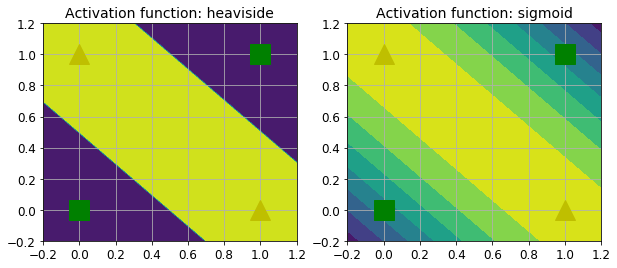

In [14]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Feedforward Neural Network (FNN)

A feedforward neural network is an artificial neural network wherein connections between the units do not form a cycle.<img src="Feed_forward_neural_net.gif">

In the training phase, the connection weights are updated through the back-propagation algorithm.

## Using tf.learn

In [15]:
import tensorflow as tf

config = tf.contrib.learn.RunConfig(tf_random_seed=42) 
feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(beetles_train_feature)

#The network has two hidden layers, 150 and 50 
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[150,50], n_classes=2,feature_columns=feature_cols, config=config)

dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # if TensorFlow >= 1.1

#fit the model with data, i.e. backpropagation to update the weights
dnn_clf.fit(beetles_train_feature, beetles_train_label, batch_size=50, steps=10000)

INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_evaluation_master': '', '_master': '', '_tf_random_seed': 42, '_task_type': None, '_num_ps_replicas': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_environment': 'local', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000022DF3D56198>, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 0, '_keep_checkpoint_max': 5, '_model_dir': 'C:\\Users\\dell\\AppData\\Local\\Temp\\tmpm7vo5nxk', '_save_checkpoints_secs': 600, '_session_config': None}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create Che

INFO:tensorflow:global_step/sec: 299.301
INFO:tensorflow:loss = 0.455779, step = 6701 (0.330 sec)
INFO:tensorflow:global_step/sec: 287.247
INFO:tensorflow:loss = 0.423839, step = 6801 (0.364 sec)
INFO:tensorflow:global_step/sec: 285.582
INFO:tensorflow:loss = 0.50906, step = 6901 (0.345 sec)
INFO:tensorflow:global_step/sec: 274.649
INFO:tensorflow:loss = 0.509007, step = 7001 (0.354 sec)
INFO:tensorflow:global_step/sec: 318.351
INFO:tensorflow:loss = 0.409096, step = 7101 (0.314 sec)
INFO:tensorflow:global_step/sec: 294.306
INFO:tensorflow:loss = 0.43488, step = 7201 (0.340 sec)
INFO:tensorflow:global_step/sec: 321.713
INFO:tensorflow:loss = 0.52938, step = 7301 (0.311 sec)
INFO:tensorflow:global_step/sec: 318.976
INFO:tensorflow:loss = 0.526143, step = 7401 (0.314 sec)
INFO:tensorflow:global_step/sec: 278.674
INFO:tensorflow:loss = 0.58716, step = 7501 (0.359 sec)
INFO:tensorflow:global_step/sec: 233.295
INFO:tensorflow:loss = 0.477291, step = 7601 (0.432 sec)
INFO:tensorflow:global_s

SKCompat()

In [16]:
from sklearn.metrics import accuracy_score

pred_label = dnn_clf.predict(beetles_train_feature)
training_accuracy = accuracy_score(beetles_train_label, pred_label['classes'])
training_accuracy

INFO:tensorflow:Restoring parameters from C:\Users\dell\AppData\Local\Temp\tmpm7vo5nxk\model.ckpt-10000


0.80393401015228427

In [17]:
pred_label = dnn_clf.predict(beetles_test_feature)
test_accuracy = accuracy_score(beetles_test_label, pred_label['classes'])
test_accuracy

INFO:tensorflow:Restoring parameters from C:\Users\dell\AppData\Local\Temp\tmpm7vo5nxk\model.ckpt-10000


0.69581749049429653

In [18]:
from sklearn.metrics import log_loss

pred_proba = pred_label['probabilities']
test_log_loss = log_loss(beetles_test_label, pred_proba)
test_log_loss

0.91592823670509615

## Using plain TensorFlow

In [19]:
import tensorflow as tf

n_inputs = len(beetles_train_feature[0])
n_hidden1 = 150
n_hidden2 = 50
n_outputs = 2


In [20]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [21]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [22]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

In [23]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [24]:
learning_rate = 0.0003

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [25]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [26]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [27]:
n_epochs = 20
batch_size = 100

In [28]:
from sklearn.utils import shuffle
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        train_feature, train_label = shuffle(beetles_train_feature, beetles_train_label, random_state = epoch)
        for iteration in range(len(beetles_train_feature) // batch_size):
            # X_batch, y_batch = mnist.train.next_batch(batch_size)
            begin_index = iteration * batch_size
            end_index = min((iteration+1) * batch_size, len(beetles_train_feature))
            # print(begin_index, end_index)
            X_batch = train_feature[begin_index:end_index]
            y_batch = train_label[begin_index:end_index]
            # print(X_batch.shape)
            # print(y_batch.shape)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: beetles_test_feature,
                                            y: beetles_test_label})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
    save_path = saver.save(sess, "./my_model_plain.ckpt")

0 Train accuracy: 0.54 Test accuracy: 0.565273
1 Train accuracy: 0.53 Test accuracy: 0.569075
2 Train accuracy: 0.54 Test accuracy: 0.57161
3 Train accuracy: 0.56 Test accuracy: 0.57161
4 Train accuracy: 0.6 Test accuracy: 0.572877
5 Train accuracy: 0.56 Test accuracy: 0.572877
6 Train accuracy: 0.56 Test accuracy: 0.572877
7 Train accuracy: 0.53 Test accuracy: 0.574144
8 Train accuracy: 0.55 Test accuracy: 0.575412
9 Train accuracy: 0.65 Test accuracy: 0.575412
10 Train accuracy: 0.6 Test accuracy: 0.576679
11 Train accuracy: 0.5 Test accuracy: 0.576679
12 Train accuracy: 0.56 Test accuracy: 0.576679
13 Train accuracy: 0.57 Test accuracy: 0.576679
14 Train accuracy: 0.59 Test accuracy: 0.576679
15 Train accuracy: 0.55 Test accuracy: 0.577947
16 Train accuracy: 0.55 Test accuracy: 0.577947
17 Train accuracy: 0.55 Test accuracy: 0.577947
18 Train accuracy: 0.62 Test accuracy: 0.577947
19 Train accuracy: 0.5 Test accuracy: 0.577947


In [29]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_plain.ckpt") # or better, use save_path
    X_new_scaled = beetles_test_feature[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_plain.ckpt


In [30]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", beetles_test_label[:20])

Predicted classes: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual classes:    [0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1]


In [31]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [32]:
show_graph(tf.get_default_graph())

## Using `dense()` instead of `neuron_layer()`

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function, except for a few minor differences:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* a few more differences are presented in chapter 11.

In [33]:
n_inputs = len(beetles_train_feature[0])
n_hidden1 = 150
n_hidden2 = 50
n_outputs = 2

In [34]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y") 

In [35]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [36]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [37]:
learning_rate = 0.0003

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [38]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [39]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [40]:
n_epochs = 20
n_batches = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        train_feature, train_label = shuffle(beetles_train_feature, beetles_train_label, random_state = epoch)
        for iteration in range(len(beetles_train_feature) // batch_size):
            begin_index = iteration * batch_size
            end_index = min((iteration+1) * batch_size, len(beetles_train_feature))
            # print(begin_index, end_index)
            X_batch = train_feature[begin_index:end_index]
            y_batch = train_label[begin_index:end_index]
            # print(X_batch.shape)
            # print(y_batch.shape)
            #X_batch, y_batch = mnist.train.next_batch(batch_size)

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
#         print(X_batch.shape)
#         print(begin_index,end_index)
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: beetles_test_feature,
                                            y: beetles_test_label})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
    save_path = saver.save(sess, "./my_model_dense.ckpt")

0 Train accuracy: 0.51 Test accuracy: 0.555133
1 Train accuracy: 0.55 Test accuracy: 0.567807
2 Train accuracy: 0.51 Test accuracy: 0.567807
3 Train accuracy: 0.55 Test accuracy: 0.569075
4 Train accuracy: 0.6 Test accuracy: 0.57161
5 Train accuracy: 0.57 Test accuracy: 0.570342
6 Train accuracy: 0.57 Test accuracy: 0.570342
7 Train accuracy: 0.51 Test accuracy: 0.572877
8 Train accuracy: 0.55 Test accuracy: 0.574144
9 Train accuracy: 0.64 Test accuracy: 0.575412
10 Train accuracy: 0.6 Test accuracy: 0.575412
11 Train accuracy: 0.5 Test accuracy: 0.575412
12 Train accuracy: 0.55 Test accuracy: 0.575412
13 Train accuracy: 0.58 Test accuracy: 0.575412
14 Train accuracy: 0.59 Test accuracy: 0.575412
15 Train accuracy: 0.55 Test accuracy: 0.575412
16 Train accuracy: 0.55 Test accuracy: 0.576679
17 Train accuracy: 0.56 Test accuracy: 0.576679
18 Train accuracy: 0.62 Test accuracy: 0.576679
19 Train accuracy: 0.49 Test accuracy: 0.576679


In [41]:
show_graph(tf.get_default_graph())